*italicised text*

File3_Model Built and Evaluation

In [ ]:
#!pip install tensorflow numpy matplotlib
!pip install seaborn


For performance improvement, I will conduct this task in Colab. Considering replicability and anonymity, I have cleared my data path, but all the data is in the compressed file, and you can set the path yourself.

In [ ]:
from google.colab import drive
import pathlib
import tensorflow as tf
import numpy as np
import pathlib
import matplotlib.pyplot as plt

drive.mount('/content/drive')
data_dir = '/content/drive/My Drive/Task2/2_class'
data_root = pathlib.Path(data_dir)

print('Tensorflow version: {}'.format(tf.__version__))

for item in data_root.iterdir():
    print(item)

all_image_path = list(data_root.glob('*/*'))
len(all_image_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Tensorflow version: 2.15.0
/content/drive/My Drive/Task2/2_class/points_in_buildings
/content/drive/My Drive/Task2/2_class/points_in_roads


1068

In [ ]:
print(f"Number of images in points_in_buildings: {len(list(data_root.glob('points_in_buildings/*')))}")
print(f"Number of images in points_in_roads: {len(list(data_root.glob('points_in_roads/*')))}")
from PIL import Image
import random

sample_images = random.sample(all_image_path, 3)
for img_path in sample_images:
    img = Image.open(str(img_path))
    img.show()
    print(f"Displaying image: {img_path}")

Number of images in points_in_buildings: 504
Number of images in points_in_roads: 564
Displaying image: /content/drive/My Drive/Task2/2_class/points_in_buildings/satellite_image_1790.png
Displaying image: /content/drive/My Drive/Task2/2_class/points_in_roads/satellite_image_595.png
Displaying image: /content/drive/My Drive/Task2/2_class/points_in_roads/satellite_image_414.png


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32
img_height = 224
img_width = 224

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,
)

TypeError: ImageDataGenerator.__init__() got an unexpected keyword argument 'shuffle'

In [ ]:
train_generator

In [ ]:
test_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
    data_root,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    data_root,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation' ,
    shuffle=False
)

Found 856 images belonging to 2 classes.
Found 212 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout


#Load pre-trained VGG-16 model without the top fully connected layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the convolutional layers of the model; I do not want to update the weights of these layers during training.for layer in base_model.layers:
    layer.trainable = False


model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

#Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 21137729 (80.63 MB)
Trainable params: 6423041 (24.50 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Apr 22 02:05:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0              41W / 300W |   8776MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
epochs = 30

#history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)


Epoch 1/30
26/26 [==============================] - 26s 967ms/step - loss: 1.3948 - accuracy: 0.6699 - val_loss: 0.5205 - val_accuracy: 0.8021
Epoch 2/30
26/26 [==============================] - 27s 1s/step - loss: 0.3733 - accuracy: 0.8532 - val_loss: 0.3403 - val_accuracy: 0.8750
Epoch 3/30
26/26 [==============================] - 27s 1s/step - loss: 0.2912 - accuracy: 0.8762 - val_loss: 0.3025 - val_accuracy: 0.8594
Epoch 4/30
26/26 [==============================] - 27s 1s/step - loss: 0.2988 - accuracy: 0.8835 - val_loss: 0.3140 - val_accuracy: 0.8542
Epoch 5/30
26/26 [==============================] - 28s 1s/step - loss: 0.2798 - accuracy: 0.8665 - val_loss: 0.2759 - val_accuracy: 0.8906
Epoch 6/30
26/26 [==============================] - 23s 902ms/step - loss: 0.3011 - accuracy: 0.8677 - val_loss: 0.3262 - val_accuracy: 0.8594
Epoch 7/30
26/26 [==============================] - 23s 898ms/step - loss: 0.3163 - accuracy: 0.8714 - val_loss: 0.2837 - val_accuracy: 0.8698
Epoch 8/30


In [ ]:
model_path = '/content/drive/My Drive/Task2/model_saved_model'
#model.save(model_path)


7/7 [==============================] - 7s 1s/step


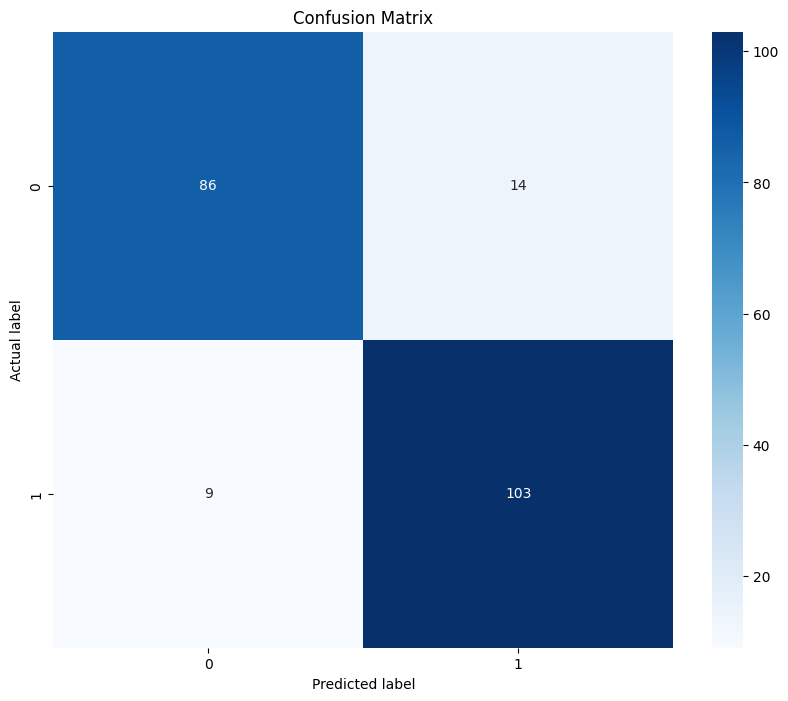

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

predictions = model.predict(validation_generator)

y_pred = (predictions > 0.5).astype(int).reshape(-1)
y_true = validation_generator.classes

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

y_pred = (predictions > 0.5).astype(int).reshape(-1)

false_positives = np.where((y_pred == 1) & (y_true == 0))[0]
false_negatives = np.where((y_pred == 0) & (y_true == 1))[0]

num_images_to_show = 5

fp_image_paths = [validation_generator.filepaths[index] for index in false_positives[:num_images_to_show]]
fn_image_paths = [validation_generator.filepaths[index] for index in false_negatives[:num_images_to_show]]
plt.figure(figsize=(25, 10))

for i, image_path in enumerate(fp_image_paths):
    plt.subplot(2, 5, i+1)
    img = load_img(image_path, target_size=(img_height, img_width))
    plt.imshow(img)
    plt.title(f'Example {i+1}\nTrue: Building \n Predicted: Street',fontsize=20)
    plt.axis('off')

for i, image_path in enumerate(fn_image_paths):
    plt.subplot(2, 5, i+6)
    img = load_img(image_path, target_size=(img_height, img_width))
    plt.imshow(img)
    plt.title(f'Example {i+6}\nTrue: Street \n Predicted: Building',fontsize=20)
    plt.axis('off')

plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tensorflow.keras.preprocessing.image import load_img
image_paths = [
    '/content/drive/My Drive/Task2/example pictures/1.1.png',
    '/content/drive/My Drive/Task2/example pictures/1.2.png',
    '/content/drive/My Drive/Task2/example pictures/1.3.png',
    '/content/drive/My Drive/Task2/example pictures/1.4.png',
    '/content/drive/My Drive/Task2/example pictures/2.1.png',
    '/content/drive/My Drive/Task2/example pictures/2.2.png',
    '/content/drive/My Drive/Task2/example pictures/2.3.png',
    '/content/drive/My Drive/Task2/example pictures/2.4.png',
    '/content/drive/My Drive/Task2/example pictures/3.1.png',
    '/content/drive/My Drive/Task2/example pictures/3.2.png',
    '/content/drive/My Drive/Task2/example pictures/3.3.png',
    '/content/drive/My Drive/Task2/example pictures/3.4.png',
 ]


image_titles = [
    'Tower Roof', 'House Roof', 'Cluster', 'Side Angle',
    'Railroad Track','Motorway', 'Parking', 'Field path',
    'Irrelevance', 'Shelter','Too Average', 'Fuzz'
]

row_titles = ['Buildings', 'Streets', 'Noises']
overall_title = 'Examples'

plt.figure(figsize=(15, 10))

gs = gridspec.GridSpec(3, 5, width_ratios=[1, 4, 4, 4, 4])

plt.suptitle(overall_title, fontsize=20, y=1.02)

for i in range(12):
    row = i // 4
    col = i % 4 + 1
    img = load_img(image_paths[i], target_size=(img_height, img_width))
    plt.subplot(gs[row, col])
    plt.imshow(img)
    plt.title(image_titles[i], fontsize=14)
    plt.axis('off')

for idx, row_title in enumerate(row_titles):
    plt.subplot(gs[idx, 0])
    plt.text(0.5, 0.5, row_title, fontsize=14, va='center', ha='center')
    plt.axis('off')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
validation_generator.reset()
steps = (validation_generator.samples // batch_size) + (1 if validation_generator.samples % batch_size > 0 else 0)
y_pred = model.predict(validation_generator, steps=steps)
y_pred = [1 if y >= 0.5 else 0 for y in y_pred.ravel()]

print('Confusion Matrix')
print(confusion_matrix(y_true, y_pred))
print('Classification Report')
print(classification_report(y_true, y_pred))


7/7 [==============================] - 8s 1s/step
Confusion Matrix
[[ 82  18]
 [  6 106]]
Classification Report
              precision    recall  f1-score   support

           0       0.93      0.82      0.87       100
           1       0.85      0.95      0.90       112

    accuracy                           0.89       212
   macro avg       0.89      0.88      0.89       212
weighted avg       0.89      0.89      0.89       212



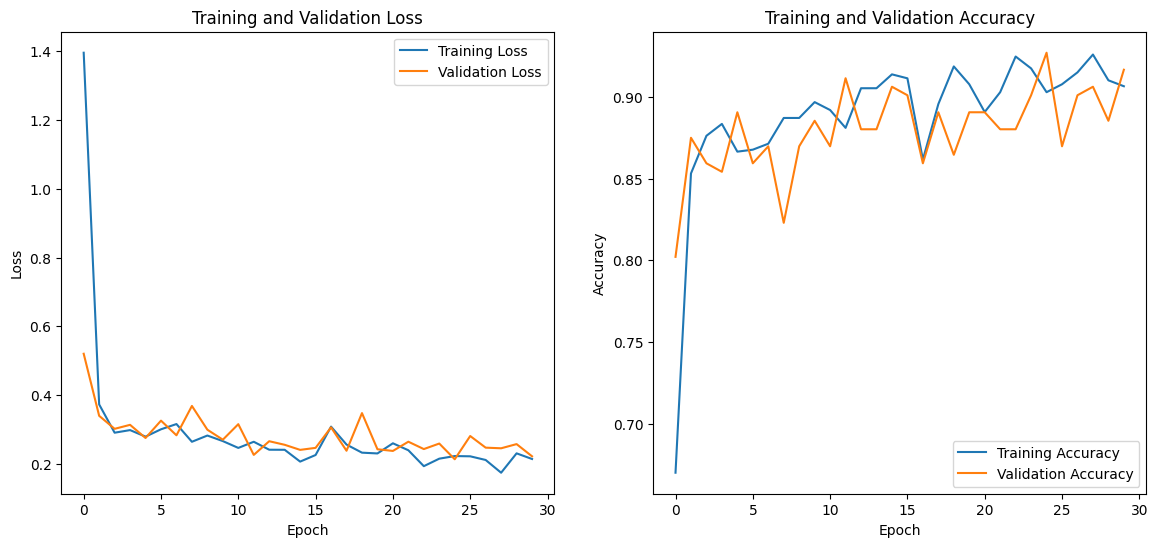

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
